In [1]:
%%time
import fastai
from fastai.vision.all import *
from pathlib import Path

CPU times: user 1.82 s, sys: 553 ms, total: 2.37 s
Wall time: 2.56 s


In [2]:
## get data
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [3]:
files

(#7390) [Path('/home/.fastai/data/oxford-iiit-pet/images/Siamese_87.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/chihuahua_126.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/german_shorthaired_97.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/Bombay_157.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/Bengal_12.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/japanese_chin_116.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/havanese_109.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/scottish_terrier_122.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_146.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/boxer_176.jpg')...]

In [5]:
class SiameseImage(fastuple):
    def show(self, ctx = None, **kwargs):
        img1, img2, same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1, t2 = tensor(img1), tensor(img2)
            # https://pytorch.org/docs/stable/generated/torch.permute.html
            t1, t2 = t1.permute(2, 0, 1), t2.permute(2, 0, 1)
        else : t1, t2 = img1, img2
        # https://pytorch.org/docs/stable/generated/torch.Tensor.new_zeros.html
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1, line, t2], dim = 2),
                          title = same_breed, ctx = ctx)

In [6]:
help(fastuple)

Help on class fastuple in module fastcore.basics:

class fastuple(builtins.tuple)
 |  fastuple(x=None, *rest)
 |  
 |  A `tuple` with elementwise ops and more friendly __init__ behavior
 |  
 |  Method resolution order:
 |      fastuple
 |      builtins.tuple
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __abs__ = _f(self, *args)
 |  
 |  __and__ = _f(self, *args)
 |  
 |  __floordiv__ = _f(self, *args)
 |  
 |  __invert__ = _f(self, *args)
 |  
 |  __lshift__ = _f(self, *args)
 |  
 |  __matmul__ = _f(self, *args)
 |  
 |  __mod__ = _f(self, *args)
 |  
 |  __neg__ = _f(self, *args)
 |  
 |  __or__ = _f(self, *args)
 |  
 |  __pos__ = _f(self, *args)
 |  
 |  __pow__ = _f(self, *args)
 |  
 |  __rshift__ = _f(self, *args)
 |  
 |  __sub__ = _f(self, *args)
 |  
 |  __truediv__ = _f(self, *args)
 |  
 |  __xor__ = _f(self, *args)
 |  
 |  add(self, *args)
 |      `+` is already defined in `tuple` for concat, so use `add` instead
 |  
 |  eq = _f(self, *args)
 |  
 |  

<AxesSubplot:title={'center':'True'}>

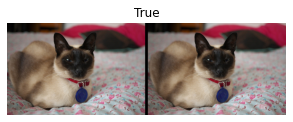

In [7]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show()

<AxesSubplot:title={'center':'False'}>

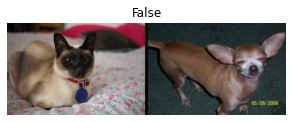

In [8]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show()

<AxesSubplot:title={'center':'False'}>

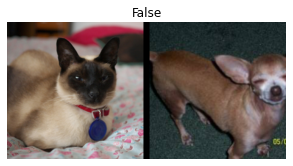

In [9]:
## Here resize will be applied to both the images but the not the boolean flag
s2 = Resize(224)(s1)
s2.show()

In [10]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [11]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l)
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2, t = self.valid.get(f, self._draw(f))
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same :
            cls = random.choice(L(l for l in self.labels if l != cls))
        return random.choice(self.lbl2files[cls]), same

In [12]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)

In [13]:
splits

((#5912) [2237,2508,2370,7001,1289,5616,28,3257,4631,7124...],
 (#1478) [5169,3284,5167,846,541,6417,5723,1199,5561,1714...])

In [14]:
files[splits[1]]

(#1478) [Path('/home/.fastai/data/oxford-iiit-pet/images/newfoundland_105.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_194.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/Birman_70.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_70.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/american_bulldog_177.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/great_pyrenees_17.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_195.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/Russian_Blue_209.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/samoyed_45.jpg'),Path('/home/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_75.jpg')...]

<AxesSubplot:title={'center':'True'}>

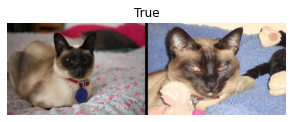

In [15]:
tfm(files[0]).show()

In [16]:
tls = TfmdLists(files, tfm, splits = splits)

<AxesSubplot:title={'center':'True'}>

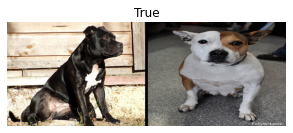

In [17]:
show_at(tls.valid, 1)

In [18]:
dls = tls.dataloaders(after_item = [Resize(224), ToTensor],
                      after_batch = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])